# GALAXY- GALAXY LENSING ANGULAR POWER SPECTRA

This notebook tests ``corfu.py`` functions. 

It compares the galaxy-galaxy lensing angular power spectrum against cosmoSIS, using DES-Y1 data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'legend.frameon': False,
    'legend.handlelength': 1.5,
})

## 1. Load CosmoSIS quantities

* Metadata

In [3]:
nbin = 4
nbinl = 5

In [4]:
bin_a, bin_b = np.tril_indices(nbin)
bin_a += 1
bin_b += 1

In [5]:
binl_a, binl_b = np.tril_indices(nbinl)
binl_a += 1
binl_b += 1

In [6]:
bin_A = np.array([1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4])
binl_B = np.array([1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5])

* Cosmology

In [7]:
cosmo = {}
with open('../data/des-y1-test/cosmological_parameters/values.txt') as cosmo_values:
    for line in cosmo_values:
        if line:
            key, val = line.partition('=')[::2]
            cosmo[key.strip()] = float(val)

In [8]:
cosmo_astropy = FlatLambdaCDM(H0=cosmo['hubble'], Ob0=cosmo['omega_b'], Om0= cosmo['omega_m'], Tcmb0=2.7)

* Distance functions

In [9]:
zdM = np.loadtxt('../data/des-y1-test/distances/z.txt')
dM = np.loadtxt('../data/des-y1-test/distances/d_m.txt')

* Matter power spectrum

In [10]:
zp = np.loadtxt('../data/des-y1-test/matter_power_nl/z.txt')
k_h = np.loadtxt('../data/des-y1-test/matter_power_nl/k_h.txt')
p_h = np.loadtxt('../data/des-y1-test/matter_power_nl/p_k.txt')

In [11]:
xp = np.interp(zp, zdM, dM)

In [12]:
k0, kf = k_h[0]*(cosmo['hubble']/100), k_h[-1]*(cosmo['hubble']/100)

In [13]:
k_h2 = np.logspace(np.log10(k0), np.log10(kf), 2048)
p_h2 = np.exp([np.interp(np.log(k_h2), np.log(k_h), np.log(p)) for p in p_h])

In [14]:
k = k_h2*cosmo['h0']
p = p_h2*cosmo['h0']**(-3)

In [15]:
p_geom = np.sqrt(p[:, None]*p[None, :])

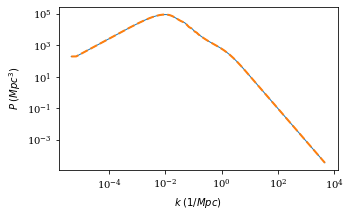

In [16]:
plt.figure(figsize=(5,3))
plt.loglog(k, p[0], lw=1)
plt.loglog(k, p_geom[0][0], '--',lw=2)
plt.xlabel(r'$k\; (1/Mpc)$')
plt.ylabel(r'$P\; (Mpc^3)$')
plt.show()

* Angular power spectrum

In [17]:
l_csis_ = np.loadtxt('../data/des-y1-test/galaxy_shear_cl/ell.txt')
cl_csis_ = [np.loadtxt('../data/des-y1-test/galaxy_shear_cl/bin_%d_%d.txt' % bins) for bins in zip(binl_B, bin_A)]

In [18]:
l_csis = np.arange(1, 100000.1, 1)
cl_csis = [np.interp(np.log(l_csis), np.log(l_csis_), cl) for cl in cl_csis_]

## 2. The correlation function

In [19]:
import corfu

In [20]:
r_limb, xi_limb = corfu.ptoxi(k, p, q=0.0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, p_geom, q=0.0)

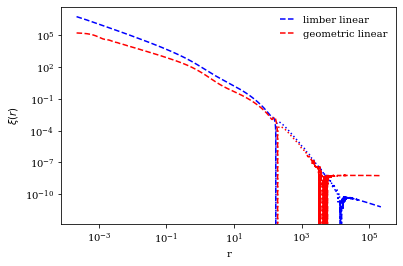

In [21]:
plt.figure(figsize=(6,4))
plt.loglog(r_limb, +xi_limb[0], '--b', label='limber linear')
plt.loglog(r_limb, -xi_limb[0], ':b')
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='geometric linear')
plt.loglog(r_geom, -xi_geom[0,0], ':r')

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [22]:
THREE_2C2 = 1.669e-11
INVERSE_C = 3.333e-6

* Redshift distribution of galaxies

Source:

In [23]:
zn = np.loadtxt('../data/des-y1-test/nz_source/z.txt')
nz = [np.loadtxt('../data/des-y1-test/nz_source/bin_%d.txt' % i) for i in range(1, nbin+1)]

In [24]:
xf = np.interp(zn, zdM, dM)

Lensed:

In [25]:
nlz = [np.loadtxt('../data/des-y1-test/nz_lens/bin_%d.txt' % i) for i in range(1, nbinl+1)]

* Lensing efficiency

In [26]:
def lensing_efficiency(x, zx, nz):
    TINY = np.finfo(0.).tiny
    return np.trapz(np.clip(x - x[:,None], 0, None) / (x + TINY) * nz, zx)

In [27]:
q = [lensing_efficiency(xf, zn, n) for n in nz]

* Convergence

In [28]:
def filter_convergence(x, zx, lens_efficiency):
    factor = THREE_2C2 * np.square(cosmo['hubble']) * cosmo['omega_m']
    return factor * (1.0 + zx) * lens_efficiency * x

In [29]:
fc = [filter_convergence(xf, zn, qq) for qq in q]

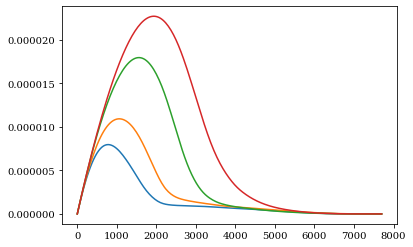

In [30]:
for qq in fc:
    plt.plot(xf, qq)
plt.show()

* Galaxy clustering

In [31]:
bias_DESY1 = [1.45, 1.55, 1.65, 1.8, 2.0]

In [32]:
def filter_galaxy_clustering(x, zx, nz, linear_bias):
    H = cosmo['hubble'] * cosmo_astropy.efunc(zx)
    return H * linear_bias * nz * INVERSE_C

In [33]:
fg = [filter_galaxy_clustering(xf, zn, n, bias) for n,bias in zip(nlz,bias_DESY1)]

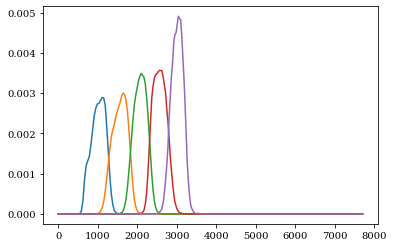

In [34]:
for qq in fg:
    plt.plot(xf, qq)
plt.show()

## 4. Angular correlation function

In [35]:
theta = np.logspace(-3, np.log10(np.pi), 512)
theta_arcmin = np.degrees(theta)*60

In [36]:
w_limb = [corfu.eqt(theta, (xf, fc[a-1]*fg[b-1]), (xp, r_limb, xi_limb)) for a, b in zip(bin_A, binl_B)]

In [37]:
w_geom = [corfu.uneqt(theta, (xf, fc[a-1]), (xf, fg[b-1]), (xp, xp, r_geom, xi_geom), True) for a, b in zip(bin_A, binl_B)]

100%|██████████| 349/349 [00:52<00:00,  6.60it/s]


In [38]:
w_csis = [corfu.cltow(cl, theta) for cl in cl_csis]

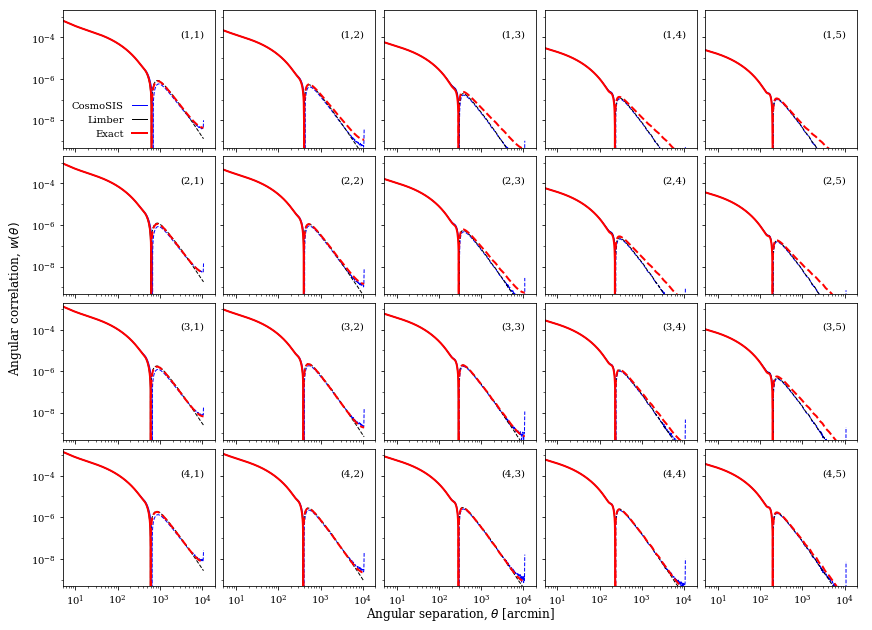

In [39]:
fig, axes = plt.subplots(4, 5, figsize=(12.5, 9), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_A, binl_B)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(theta_arcmin, +w_csis[i], 'b', label='CosmoSIS', lw=1)
    ax.loglog(theta_arcmin, -w_csis[i], '--b', lw=1)
    ax.loglog(theta_arcmin, +w_limb[i], 'k', label='Limber', lw=1)
    ax.loglog(theta_arcmin, -w_limb[i], '--k', lw=1)
    ax.loglog(theta_arcmin, +w_geom[i], 'r', label='Exact', lw=2)
    ax.loglog(theta_arcmin, -w_geom[i], '--r', lw=2)
    ax.set_xlim(5e0, 2e4)
    ax.set_ylim(5e-10, 2e-3)
    ax.set_xticks([1e1, 1e2, 1e3, 1e4])
    ax.set_yticks([1e-3, 1e-5, 1e-7, 1e-9], minor=True)
    ax.tick_params(axis='y', which='minor', labelcolor='none')
    string = '({0},{1})'.format(a,b)
    ax.text(3e3,1e-4,string)

axes[0, 0].legend(markerfirst=False, loc='lower left')

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular separation, $\theta$ [arcmin]', size=12)
ax.set_ylabel(r'Angular correlation, $w(\theta)$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=15)

fig.tight_layout(pad=0.5)
# fig.savefig('plots/w_galaxy_lensing.pdf', bbox_inches='tight')

plt.show()

## 5. Angular power spectra

* Convergence

In [40]:
l_limb, cl_limb = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_limb], (1, 0, 2))

In [41]:
l_geom, cl_geom = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_geom], (1, 0, 2))

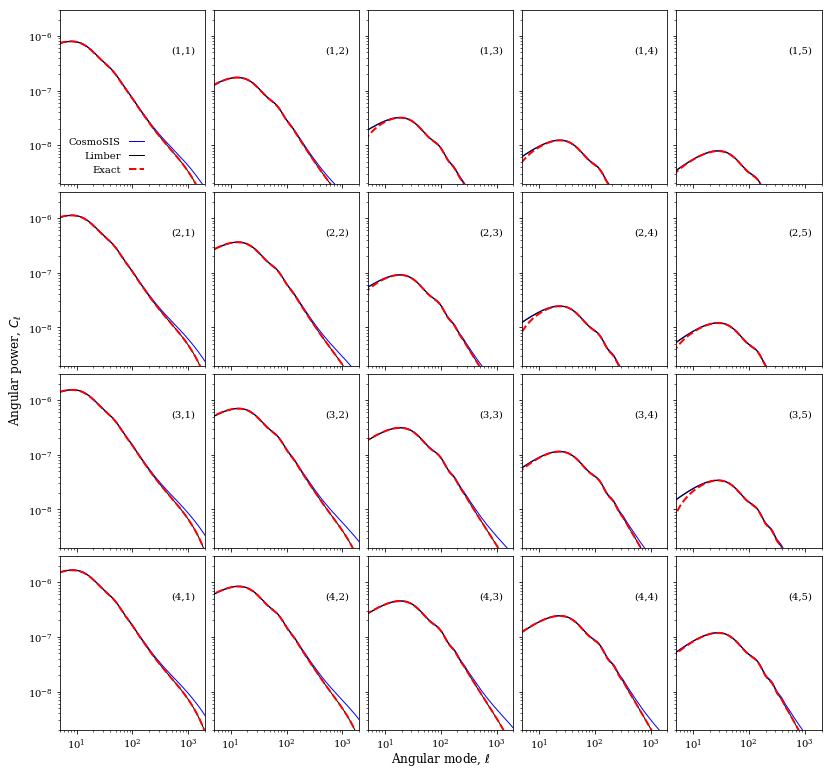

In [42]:
fig, axes = plt.subplots(4, 5, figsize=(12, 11), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_A, binl_B)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(l_csis, cl_csis[i], 'b', label='CosmoSIS', lw=1)
    ax.loglog(l_limb[i], cl_limb[i], 'k', label='Limber', lw=1)
    ax.loglog(l_geom[i], cl_geom[i], '--r', label='Exact', lw=2)
    ax.set_xlim(5e0, 2e3)
    ax.set_ylim(2e-9, 3e-6)
    ax.set_xticks([1e1, 1e2, 1e3])
    string = '({0},{1})'.format(a,b)
    ax.text(5e2,5e-7,string)

axes[0, 0].legend(markerfirst=False, loc='lower left')

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'Angular power, $C_{\ell}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

fig.tight_layout(pad=0.5)
# fig.savefig('plots/cl_galaxy_lensing.pdf', bbox_inches='tight')

plt.show()